# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/sanj909/cme241/blob/master/assignments/assignment4.ipynb

*Group members (replace below names with people in your group):* 
- Sanjit Neelam

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import Sequence, Tuple, TypeVar

from rl.approximate_dynamic_programming import evaluate_mrp as approx_evaluate_mrp
from rl.approximate_dynamic_programming import extended_vf as approx_extended_vf
from rl.approximate_dynamic_programming import value_iteration as approx_value_iteration
from rl.approximate_dynamic_programming import extended_vf as approx_extended_vf
from rl.chapter3.simple_inventory_mdp_cap import (InventoryState,
                                                  SimpleInventoryMDPCap)
from rl.distribution import Choose, Distribution
from rl.dynamic_programming import policy_iteration_result
from rl.iterate import converged
from rl.function_approx import FunctionApprox, Tabular
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        MarkovDecisionProcess)
from rl.markov_process import (FiniteMarkovRewardProcess, MarkovRewardProcess,
                               NonTerminal, State)
from rl.policy import DeterministicPolicy, FiniteDeterministicPolicy, Policy

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [2]:
S = TypeVar('S')
A = TypeVar('A')

ValueFunctionApprox = FunctionApprox[NonTerminal[S]]
NTStateDistribution = Distribution[NonTerminal[S]]

def approx_greedy_policy_from_vf(
        mdp: MarkovDecisionProcess[S, A],
        vf: ValueFunctionApprox[S],
        gamma: float
    ) -> DeterministicPolicy[S, A]:

    def return_(s_r: Tuple[State[S], float]) -> float:
        s1, r = s_r
        return r + gamma * approx_extended_vf(vf, s1)

    def improved_action_for(state: S) -> A:
        return max(
            [(a, mdp.step(NonTerminal(state), a).expectation(return_))
                for a in mdp.actions(NonTerminal(state))],
            key=lambda x: x[1]
        )[0]
    
    return DeterministicPolicy(improved_action_for)

def approx_policy_iteration_step(
        mdp: MarkovDecisionProcess[S, A],
        gamma: float,
        approx_0: ValueFunctionApprox[S],
        non_terminal_states_distribution: NTStateDistribution[S],
        num_state_samples: int,
        pi: Policy[S, A]
    ) -> Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]:

    mrp: MarkovRewardProcess[S] = mdp.apply_policy(pi)

    policy_vf: ValueFunctionApprox[S] = converged(
        approx_evaluate_mrp(
            mrp, 
            gamma, 
            approx_0, 
            non_terminal_states_distribution, 
            num_state_samples
        ),
        done=lambda a, b: a.within(b, 1e-2)
    )

    improved_pi: DeterministicPolicy[S, A] = approx_greedy_policy_from_vf(
        mdp, 
        policy_vf, 
        gamma
    )

    return policy_vf, improved_pi

- Ensure that *Approximate Policy Iteration* gives the same Optimal Value Function/Optimal Policy as that obtained by *Approximate Value  Iteration*.
- We use `SimpleInventoryMDP` from `rl.test_approx_dp_inventory`.

In [3]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
gamma = 0.9

si_mdp: FiniteMarkovDecisionProcess[InventoryState, int] = \
    SimpleInventoryMDPCap(
        capacity=user_capacity,
        poisson_lambda=user_poisson_lambda,
        holding_cost=user_holding_cost,
        stockout_cost=user_stockout_cost
    )

fdp: FiniteDeterministicPolicy[InventoryState, int] = \
        FiniteDeterministicPolicy(
            {InventoryState(alpha, beta): user_capacity - (alpha + beta)
                for alpha in range(user_capacity + 1)
                for beta in range(user_capacity + 1 - alpha)}
        )

implied_mrp: FiniteMarkovRewardProcess[InventoryState] = \
    si_mdp.apply_finite_policy(fdp)

states: Sequence[NonTerminal[InventoryState]] = \
    implied_mrp.non_terminal_states

In [4]:
print("-" * 80)
print("Approximate value iteration")
print("-" * 80)

fa = Tabular(
    {s: 0.0 for s in states}, 
    {s: 0 for s in states},
    lambda x: 1.0
)

mdp_fa = converged(
    approx_value_iteration(
        si_mdp,
        gamma,
        fa,
        Choose(states),
        num_state_samples=30
    ),
    done=lambda a, b: a.within(b, 1e-5)
)

vf_avi: np.ndarray = mdp_fa.evaluate(states)
pi_avi: FiniteDeterministicPolicy[InventoryState, int] = \
    approx_greedy_policy_from_vf(si_mdp, mdp_fa, gamma)

print(f"Optimal value function:\n{vf_avi}\n")
print(f"Optimal policy:")
for s in states:
    print(f"For State {s.state}: Do Action {pi_avi.act(s).value}")
print("-" * 80)

--------------------------------------------------------------------------------
Approximate value iteration
--------------------------------------------------------------------------------
Optimal value function:
[-43.59562637 -37.97110503 -37.32848367 -38.97110503 -38.32848367
 -39.32848367]

Optimal policy:
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0
--------------------------------------------------------------------------------


In [5]:
print("-" * 80)
print("Approximate policy iteration")
print("-" * 80)

vf_api = Tabular(
    {s: 0.0 for s in states}, 
    {s: 0 for s in states},
    lambda x: 1.0
)

pi_api = DeterministicPolicy(
    lambda s: 0
)

MAX_ITER = 10

for _ in tqdm(range(MAX_ITER)):
    vf_api, pi_api = approx_policy_iteration_step(
        si_mdp,
        gamma,
        vf_api,
        Choose(states),
        4,
        pi_api
    )

print(f"Optimal value function:\n{vf_api.evaluate(states)}\n")
print(f"Optimal policy:")
for s in states:
    print(f"For State {s.state}: Do Action {pi_api.act(s).value}")
print("-" * 80)

--------------------------------------------------------------------------------
Approximate policy iteration
--------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

Optimal value function:
[-43.58922712 -37.9571232  -37.31268273 -38.96532023 -38.35051558
 -39.34170487]

Optimal policy:
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0
--------------------------------------------------------------------------------


In [6]:
print(f"""RMSE between value functions obtained by API and AVI:
{np.sqrt(np.mean((vf_avi - vf_api.evaluate(states))**2))}""")

RMSE between value functions obtained by API and AVI:
0.014022486801978835


- Ensure that *Approximate Policy Iteration* produces the same result as our prior implementation of Policy Iteration (in file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
- We use `SimpleInventoryMDP` from `rl.test_approx_dp_inventory`.

In [7]:
print("-" * 80)
print("Exact policy iteration")
print("-" * 80)

vf_policy_epi: Tuple[NonTerminal[S], FiniteDeterministicPolicy[InventoryState, float]] = \
    policy_iteration_result(
        si_mdp,
        gamma
)

vf_epi, pi_epi = vf_policy_epi

print(f"Optimal value function:\n{np.array(list(vf_epi.values()))}\n")
print(f"Optimal policy:")
for s in states:
    print(f"For State {s.state}: Do Action {pi_epi.act(s).value}")
print("-" * 80)

--------------------------------------------------------------------------------
Exact policy iteration
--------------------------------------------------------------------------------
Optimal value function:
[-43.59563313 -37.97111179 -37.32849044 -38.97111179 -38.32849044
 -39.32849044]

Optimal policy:
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0
--------------------------------------------------------------------------------


In [8]:
print(f"""RMSE between value functions obtained by API and PI:
{np.sqrt(np.mean((np.array(list(vf_epi.values())) - vf_api.evaluate(states))**2))}""")

RMSE between value functions obtained by API and PI:
0.014023027967703692


## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

- We have
\begin{align*}
    \mathbb{E}[U(x)] &= \mathbb{E}\left[x - \frac{\alpha x^2}{2}\right] \\
                     &= \mathbb{E}[x] - \frac{\alpha}{2} \mathbb{E}[x^2] \\
                     &= \mu - \frac{\alpha}{2} (\mu^2 + \sigma^2).
\end{align*}
- Then the certainty-equivalent value $x_{CE}$ satisfies
\begin{alignat*}{2}
    &\qquad& U(x_{CE}) &= \mathbb{E}[U(x)] \\
    \iff&& x_{CE} - \frac{\alpha x_{CE}^2}{2} &= \mu - \frac{\alpha}{2} (\mu^2 + \sigma^2) \\
    \iff&& \alpha x_{CE}^2 - 2x_{CE} + 2\mu - \alpha (\mu^2 + \sigma^2) &= 0 \\
    \implies&& x_{CE} &= \frac{2 \pm \sqrt{4 - 4 \alpha (2\mu - \alpha (\mu^2 + \sigma^2))}}{2 \alpha} \\
    \implies&& x_{CE} &= \frac{1 + \sqrt{(\alpha \mu - 1)^2 + (\alpha \sigma)^2}}{\alpha}
\end{alignat*}
to guarantee $x_{CE} > 0$.
- Then the absolute risk-premium $\pi_A$ is
\begin{align*}
    \pi_A &= \mathbb{E}[x] - x_{CE} \\
          &= \mu - \frac{1 + \sqrt{(\alpha \mu - 1)^2 + (\alpha \sigma)^2}}{\alpha}.
\end{align*}

- Let $z$ be the fraction of a million dollars that we invest in the risky asset. Then the value $W$ of our portfolio in one year satisfies
\begin{align*}
    W &= z (1 + \mathcal{N}(\mu, \sigma^2)) + (1-z)(1+r) \\
    \implies W &\sim \mathcal{N}(1 + r + z(\mu - r), z^2 \sigma^2),
\end{align*}
so the optimal value of $z$ maximises 
\begin{align*}
    \mathbb{E}[U(W)]  &=  1 + r + z(\mu - r) - \frac{\alpha}{2} ((1 + r + z(\mu - r))^2 + z^2 \sigma^2). \\
\end{align*}
We have
\begin{alignat*}{2}
    && \frac{d}{dz} \mathbb{E}[U(W)] &= \mu - r - \alpha (1 + r + z(\mu - r)) (\mu - r) - \alpha z \sigma^2 \\
    &&                               &= \mu - r - \alpha (1 + r) (\mu - r) - \alpha z (\mu - r)^2 - \alpha z \sigma^2 \\
    &&                               &= (\mu - r) (1 - \alpha (1 + r)) - z (\alpha (\mu - r)^2 + \alpha \sigma^2), \\
    &&                               &= 0 \\
    \implies&&                     z &= \frac{(\mu - r) (1 - \alpha (1 + r))}{\alpha (\mu - r)^2 + \alpha \sigma^2}, \\                        
    && \text{sign} \left( \frac{d^2}{dz^2} \mathbb{E}[U(W)] \right) &= \text{sign} \left( -\alpha (\mu - r)^2 - \alpha \sigma^2 \right) \\
    &&                                                              &= - \text{sign} ( \alpha ),
\end{alignat*}
so the optimal value of $z$ is
\begin{align*}
    z^* &= \frac{(\mu - r) (1 - \alpha (1 + r))}{\alpha (\mu - r)^2 + \alpha \sigma^2}
\end{align*}
for $\alpha > 0$.

- We also note that for the utility function $U$ to be concave, we must have
\begin{alignat*}{2}
    &\qquad& U(\mathbb{E}[x]) &\geq \mathbb{E}[U(x)] \\
    \iff&& \mu - \frac{\alpha \mu^2}{2} &\geq \mu - \frac{\alpha}{2} (\mu^2 + \sigma^2) \\
    \iff&& 0 &\geq - \frac{\alpha \sigma^2}{2} \\
    \implies&& \alpha &\geq 0.
\end{alignat*}

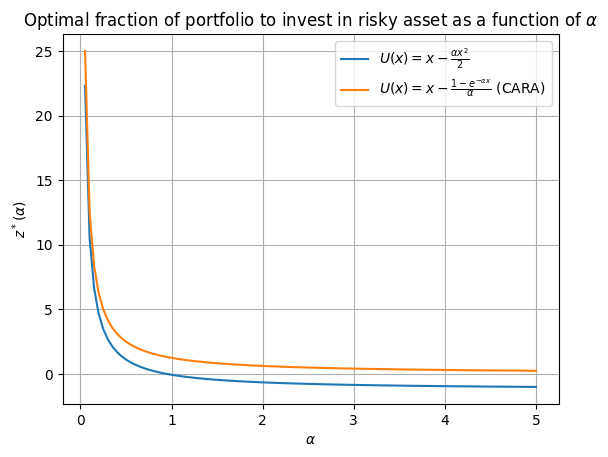

In [9]:
mu = 0.10
sigma = 0.2
r = 0.05
alpha = np.linspace(0, 5, 101)[1:]

f = lambda mu, sigma, r, alpha: ((mu - r) * (1 - alpha * (1 + r))) \
                                / (alpha * (mu - r)**2 + alpha * sigma**2)
g = lambda mu, sigma, r, alpha: (mu - r) / (alpha * sigma**2)

plt.plot(alpha, f(mu, sigma, r, alpha), label='$U(x) = x - \\frac{\\alpha x^2}{2}$');
plt.plot(alpha, g(mu, sigma, r, alpha), label='$U(x) = x - \\frac{1-e^{-\\alpha x}}{\\alpha}$ (CARA)');
plt.xlabel('$\\alpha$');
plt.ylabel('$z^*(\\alpha)$');
plt.title('Optimal fraction of portfolio to invest in risky asset as a function of $\\alpha$')
plt.grid(True);
plt.legend();

- The optimal value of $z$ with $U_1(x) = x - \frac {\alpha x^2} 2$ is smaller than the optimal value of $z$ with $U_2(x) = \frac{1 - e^{-\alpha x}}{\alpha}$ (Constant Absolute Risk-Aversion (CARA)), which implies that an agent whose utility function is $U_1$ should invest a smaller fraction of their million dollars in the risky asset to maximise their expected utility in one year.
- This makes sense since
    - $U_1$ is "more concave" than $U_2$, and the extent of concavity of the utility function determines the extend of risk-aversion of the agent.
    - If $x$ is the value of the agent's portfolio in one year, an agent whose utility function is $U_1$ obtains negative marginal utility (decreasing accumulated utility) for $x > \frac{1}{\alpha}$ since $U_1'(x) = 1 - \alpha x$, but an agent whose utility function is $U_2$ obtains positive marginal utility (increasing accumulated utility) for all $x > 0$ since $U_2'(x) = e^{-\alpha x} > 0$.

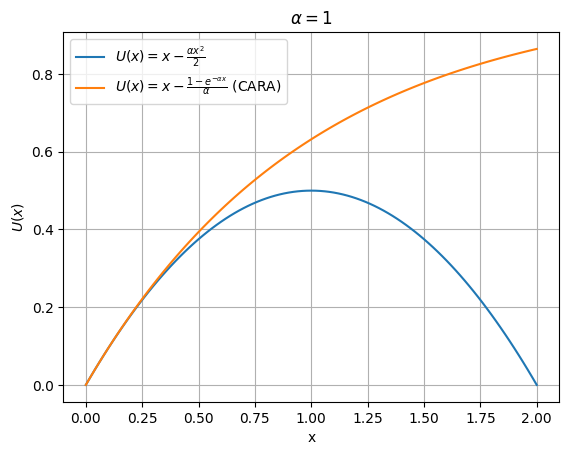

In [10]:
alpha = 1
x = np.linspace(0, 2, 101)
plt.plot(x, x - ((alpha * x**2) / 2), label='$U(x) = x - \\frac{\\alpha x^2}{2}$');
plt.plot(x, (1 - np.exp(-alpha * x)) / alpha, label='$U(x) = x - \\frac{1-e^{-\\alpha x}}{\\alpha}$ (CARA)');
plt.xlabel('x');
plt.ylabel('$U(x)$');
plt.title(f'$\\alpha = {alpha}$')
plt.grid(True);
plt.legend();

$$

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


- The two outcomes for wealth $W$ at the end of a single bet of $f W_0$ are
\begin{align*}
    \begin{cases} f W_0 (1 + \alpha) + (1-f)W_0 & \text{with probability $p$} \\ f W_0 (1 - \beta) + (1-f)W_0 & \text{with probability $q$} \end{cases} = \begin{cases} W_0 (1 + \alpha f) & \text{with probability $p$} \\ W_0 (1 - \beta f) & \text{with probability $q$} \end{cases}.
\end{align*}
- The two outcomes for utility of wealth $U(W)$ at the end of a single bet of $f W_0$ are
\begin{align*}
    \begin{cases} \log(W_0 (1 + \alpha f)) & \text{with probability $p$} \\ \log(W_0 (1 - \beta f)) & \text{with probability $q$} \end{cases}.
\end{align*}
- The expected utility of wealth at the end of a single bet of $f W_0$ is
\begin{align*}
    \mathbb{E}[\log(W)] &= p \log(W_0 (1 + \alpha f)) + q \log(W_0 (1 - \beta f)). \\
\end{align*}
- We have 
\begin{alignat*}{2}
    &\qquad& \frac{d}{df} \mathbb{E}[\log(W)] &= \frac{p \alpha W_0}{W_0 (1 + \alpha f)} - \frac{q \beta W_0}{W_0 (1 - \beta f)} \\
    &&                                        &= \frac{p \alpha (1 - \beta f) - q \beta (1 + \alpha f)}{(1 + \alpha f)(1 - \beta f)} \\
    &&                                        &= \frac{p \alpha + p \beta - \beta - \alpha \beta f}{(1 + \alpha f)(1 - \beta f)}.
\end{alignat*}
- Then 
\begin{alignat*}{2}
    &\qquad& \frac{d}{df} \mathbb{E}[\log(W)] &= 0 \\
    \iff&& p \alpha + p \beta - \beta - \alpha \beta f &= 0 \\
    \iff&& f &= \frac{p \alpha + p \beta - \beta}{\alpha \beta}.
\end{alignat*}
- Without loss of generality $\alpha, \beta > 0$, so
\begin{align*}
    \frac{d^2}{df^2} \mathbb{E}[\log(W)] &= \frac{d}{df} \frac{- \alpha \beta f}{1 - \beta f + \alpha f - \alpha \beta f^2} \\
                                         &= \frac{- \alpha \beta (\alpha \beta f^2 + 1)}{(1 - \beta f + \alpha f - \alpha \beta f^2)^2} \\
                                         &< 0.
\end{align*}
- Thus 
\begin{align*}
    f^* &= \frac{p \alpha + p \beta - \beta}{\alpha \beta} = \frac{p \alpha - q \beta}{\alpha \beta} = \frac{p}{\beta} - \frac{q}{\alpha}
\end{align*}
is the fraction of wealth that should be bet to maximise the expected utility of wealth at the end of that bet.
- Suppose $\alpha, \beta$, and $p$ are given. 
    - It makes sense that $f^*=0$ whenever the expected return of the bet, $p \alpha - q \beta$, is equal to zero.
    - We have $\frac{d}{d\alpha} f^* = \frac{q}{\alpha^2} > 0$, so $f^*$ increases as $\alpha$ increases. We also have $\frac{d}{d\beta} f^* = -\frac{p}{\beta^2} < 0$, so $f^*$ increases as $\beta$ decreases. Thus the Kelly criterion suggests that we should bet a larger (smaller) fraction of our wealth if the expected return $p \alpha - q \beta$ is larger (smaller), which makes intuitive sense.

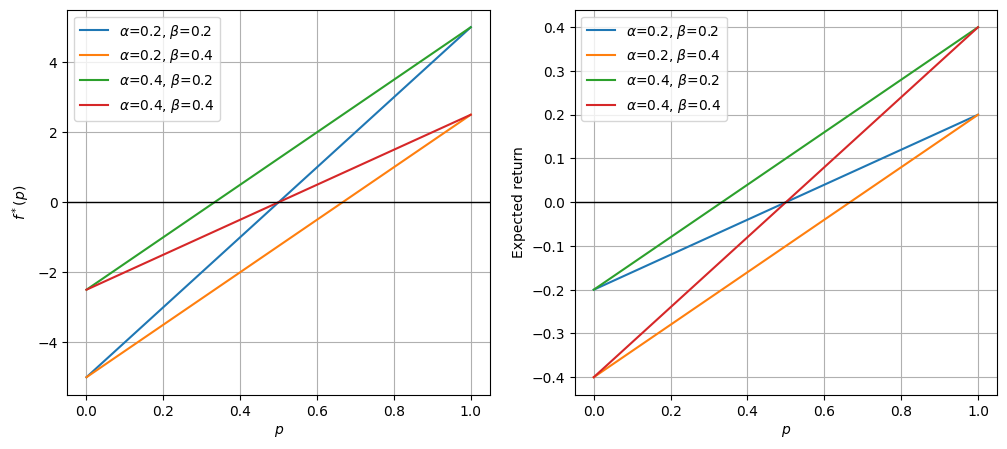

In [11]:
alphas = [0.2, 0.4]
betas = [0.2, 0.4]
f_star = lambda alpha, beta, p: (p / beta) - ((1 - p) / alpha)
expected_return = lambda alpha, beta, p: p * alpha - (1 - p) * beta
p = np.linspace(0, 1, 101)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for alpha in alphas:
    for beta in betas:
        ax[0].plot(p, f_star(alpha, beta, p), 
                   label=f'$\\alpha$={alpha}, $\\beta$={beta}')
        ax[1].plot(p, expected_return(alpha, beta, p),
                   label=f'$\\alpha$={alpha}, $\\beta$={beta}'),
ax[0].axhline(0, color='black', lw=1)
ax[0].set_xlabel('$p$')
ax[0].set_ylabel('$f^*(p)$')
ax[0].grid(True)
ax[0].legend()
ax[1].axhline(0, color='black', lw=1)
ax[1].set_xlabel('$p$')
ax[1].set_ylabel('Expected return')
ax[1].grid(True)
ax[1].legend();

- We can observe the effect of the concave utility function $U(W) = \log(W)$ by comparing the Kelly criteria for the red and blue curves when $p=1$ and $p=0$.
    - When $p=1$ the bet is certain to increase the agent's wealth. The expected return of the red curve is higher than that of the blue curve, but the Kelly criterion for the red curve is smaller than that for the blue curve.
    - When $p=0$ the bet is certain to decrease the agent's wealth. The expected return of the red curve is lower than that of the blue curve, but the Kelly criterion for the red curve is higher than that for the blue curve.
    - In both of these cases, if the agent's utility function was linear we would expect the optimal fraction of wealth to bet to be the same for the red curve and the blue curve.

## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.